<a href="https://colab.research.google.com/github/aleksejalex/DYNR1cv_2025/blob/main/DYNR1cv_03_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DYNR1cv - Policy iteration.

Prepared by: *Aleksej Gaj* ([email](mailto:aleksejalex@gmail.com))



In [1]:
#%%capture
%pip install gymnasium
%pip install pygame

In [2]:
# imports:
import random
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display

## Policy Iteration (PI)

### Setup - "the lake has frozen"...

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over
the frozen lake.

The player may not always move in the intended direction due to the slippery nature of the
frozen lake.

[official documentation](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

[unoficial tutorial](https://aleksandarhaber.com/installation-and-getting-started-with-openai-gym-and-frozen-lake-environment-reinforcement-learning-tutorial/)



### Formalization:

**Actions**:

| Action  | Description |
|---------|-------------|
| `0`       | Move Left   |
| `1`       | Move Down   |
| `2`       | Move Right  |
| `3`       | Move Up     |

**States**:
`nrows`x`ncols` grid, player’s current position = `current_row * nrows + current_col` (where both the row and col start at 0).

**Starting state**:
 - always state `[0]` (ie. location [0, 0])

**Rewards**:

| Reward  | Description                       |
|---------|-----------------------------------|
| 0       | Frozen surface (Safe)             |
| 1       | Goal (Reach the goal)             |
| 0       | Hole (Fall into a hole)           |

**Terminal state(s)**:
 - goal (`G`) ... "win"
 - any hole (`H`) ... "lose"

**Is slippery?**
 - agent can the the action with p=1/3 and the "orthogonal" actions also with  p = 1/3 each

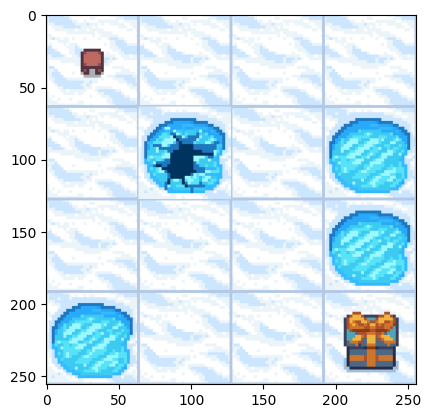

In [3]:
# Example of the problem:
env = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array", is_slippery=False)
state=env.reset()[0]
done=False

while not done:
    action=env.action_space.sample()
    new_state, reward, done, info, x = env.step(action)
    img=plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

### PI - the code

Technical remark:
`np.argmax()` gets an array and returns index of the greatest element

In [4]:
np.argmax([2,3,100])

np.int64(2)

In [6]:
def policy_evaluation(env, policy, gamma=0.99, epsilon=1e-3):
    """this function finds value function for a given policy: pi --> V^{pi}"""
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    V = np.zeros(num_states)
    P = env.unwrapped.P  # more modern, instead of using directly 'env.P'

    while True:  # basically VI without maximum
        delta = 0
        for s in range(num_states):
            v = V[s]
            new_v = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in P[s][a]:
                    new_v += action_prob * prob * (reward + gamma * V[next_state])
            V[s] = new_v
            delta = max(delta, abs(v - V[s]))
        if delta < epsilon:
            break
    return V


def policy_improvement(env, V, gamma=0.99):
    """calculate new policy"""
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    new_policy = np.zeros((num_states, num_actions))
    P = env.unwrapped.P  # more modern, instead of using directly 'env.P'
    for s in range(num_states):
        q_values = np.zeros(num_actions)
        for a in range(num_actions):
            for prob, next_state, reward, done in P[s][a]:
                q_values[a] += prob * (reward + gamma * V[next_state])
        best_action = np.argmax(q_values) # action maximising V found by policy_evaluation() is found
        new_policy[s, best_action] = 1 # so for each state best action is 'marked' by 1 (other actions have 0)
        # NB: policy in MDP is deterministic
    return new_policy


def policy_iteration(env, gamma=0.99):
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    num_of_iter = 0
    policy = np.ones((num_states, num_actions)) / num_actions # uniform
    while True:
        num_of_iter = num_of_iter + 1
        V = policy_evaluation(env, policy, gamma)
        new_policy = policy_improvement(env, V, gamma)
        if np.array_equal(new_policy, policy):
            break # no improvement possible for ANY state
        policy = new_policy
    print(f"Policy iterated {num_of_iter} iterations.")
    return V, policy

1. take policy $\pi$
2. evalutate policy $\pi$ i.e. find function $V^{\pi}$ (`policy_evaluation()`)
3. improve policy $\pi$ by taking $V^{\pi}$ and selecting new greedy policy (`policy_improvement()`)
4. improvement ends when no improving action is possible in **any** state

### PI - optimal policy

In [7]:
# define the environment
env = gym.make("FrozenLake-v1", map_name="4x4", render_mode="rgb_array", is_slippery=True)
#alternative env = gym.make("FrozenLake-v1", desc=generate_random_map(size=4), render_mode="rgb_array", is_slippery=True)
# policy iteration (implemented above)
optimal_V, optimal_policy = policy_iteration(env)

Policy iterated 3 iterations.


In [8]:
def convert_policy(policy_vectors):
    num_of_states = policy_vectors.shape[0]
    policy_nums = np.zeros(num_of_states, dtype=np.int32)
    for i in range(num_of_states):
        action = policy_vectors[i]
        if np.array_equal(action, np.array([1, 0, 0, 0])):
            policy_nums[i] = 0
        if np.array_equal(action, np.array([0, 1, 0, 0])):
            policy_nums[i] = 1
        if np.array_equal(action, np.array([0, 0, 1, 0])):
            policy_nums[i] = 2
        if np.array_equal(action, np.array([0, 0, 0, 1])):
            policy_nums[i] = 3
    return policy_nums

In [9]:
print("Optimal Value Function:")
print(optimal_V)
print("Optimal Policy:")
print(optimal_policy)

Optimal Value Function:
[0.52986887 0.48271651 0.45190343 0.43669411 0.54765353 0.
 0.35023294 0.         0.58299795 0.63675282 0.60967995 0.
 0.         0.73736176 0.86063736 0.        ]
Optimal Policy:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [10]:
optimal_policy = convert_policy(optimal_policy)
print(optimal_policy)

[0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


### PI - visualize

In [11]:
# initialize the env
state=env.reset()[0]
done=False

In [12]:
optimal_policy

array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0], dtype=int32)

Elf made 12 steps.


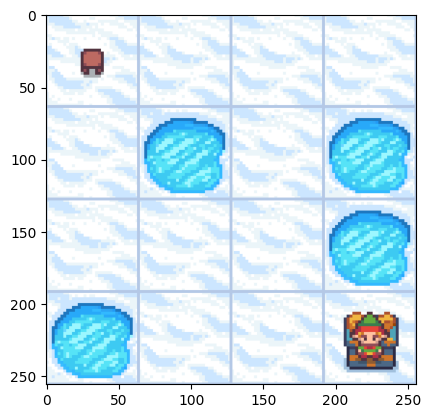

In [13]:
#in cycle: make action and show the situation
num_of_steps = 0
while not done:
    action = optimal_policy[state]
    new_state, reward, done, info, x = env.step(action)

    img=plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state = new_state

    num_of_steps = num_of_steps + 1
print(f"Elf made {num_of_steps} steps.")